### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


### 1. Project parameters

In [1]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

C:\Users\19904604\AppData\Local\Temp\ipykernel_15780\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [2]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2000, 2000), (2500, 2000), (2500, 2500), (2000, 2500)] 
P.idpumpbores = ['P0','P1','P2','P3'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (1500, 3500), (4500,4500)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4', 'OB5'] 
P.nobs = len(P.xyobsbores)
P.nzobs = 3
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 50000 
P.modelmaxtri = 50000 # 10000 for ref
P.angle = 32   # minimum triangle angles

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 100000

#P.geo_bores = ['P1', 'P2', 'P3', 'P4']
#P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 3 # Number sublayers for conformable
P.geo_pl = 2 # Which geological layer pumping from (zero-based)

P.hk = [1, 0.1, 5, 0.1] 
P.vk = [i/10 for i in P.hk]

P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.

P.ss = [0.00005, 0.00005, 0.00005, 0.00005]
P.sy = [0.1, 0.1, 0.1, 0.1]
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True

past_years = 2
P.nts_past = past_years * 6
P.tdis_past = [(past_years * 365, P.nts_past, 1.2)] # period length, number of timesteps, tsmult
P.qwell_past = -2000 #m3/d 

future_years = 5
P.nts_future = future_years * 6
P.tdis_future = [(future_years * 365, P.nts_future, 1.2)] # period length, number of timesteps, tsmult
P.qwell_future = -5000 #m3/d 

#P.zobs = [-50, -100, -200]
   
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(workspace, exist_ok=True)

### 2. Meshing

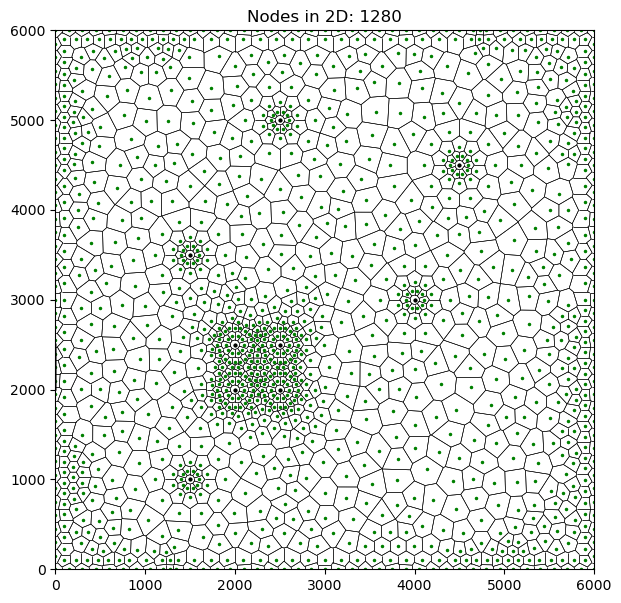

In [3]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)      
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

P.nlv  = 30  
P.delx, P.dely = 40, 40
P.ncol, P.nrow = int((P.x1 - P.x0) / P.delx), int((P.y1 - P.y0) / P.dely)
P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False)    

### 3. Geological model (Reference)

In [4]:
P.control_points = ([])
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "inverse_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)     # Prepare geomodel inputs
P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


{'upper': 0, 'upper_unconformity': 1, 'lower': 2}


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


In [5]:
#P.data
#P.geomodel.feature_names()
#plot_bores(P)

### 4. Flow model (Reference)

In [6]:
# Initiate REFERENCE
R = Model('ref', P, plan = 'vor', transect = 'con') 
R.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)

Creating lithology and discretisation arrays for  ref  ...
Time taken =  2.725523


In [7]:
P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_icpl, wel_coords = find_cell_disv(P.xypumpbores[n][0], P.xypumpbores[n][1], R.xcyc)
    if P.geo_pl == 0:
        wel_top = R.top[wel_icpl]  
    else:   
        wel_top = R.botm[(P.geo_pl)* P.nls-1, wel_icpl]
    wel_bot = R.botm[(P.geo_pl + 1) * P.nls-1, wel_icpl]   
    print(wel_coords, wel_top, wel_bot)
    P.wel_screens.append((wel_top, wel_bot))
    
P.zobs = np.zeros((P.nobs,P.nzobs))
for n in range(len(P.xyobsbores)):
    obs_icpl, obs_coords = find_cell_disv(P.xyobsbores[n][0], P.xyobsbores[n][1], R.xcyc) # Cell id in plan
    for m in range(3): # For the top three geological layers
        if m == 0:
            lay_top = R.top[obs_icpl]  
        else:   
            lay_top = R.botm[(m)* P.nls-1, obs_icpl]
        lay_bot = R.botm[(m + 1) * P.nls-1, obs_icpl]   
        obsz = lay_bot + (lay_top-lay_bot)/2
        P.zobs[n][m] = obsz
P.zobs

(2000.0, 2000.0) -186.0 -288.0
(2500.0, 2000.0) -164.0 -266.0
(2500.0, 2500.0) -148.0 -250.0
(2000.0, 2500.0) -164.0 -266.0


array([[ -25., -162., -326.],
       [ -25.,  -50., -101.],
       [ -25.,  -60., -121.],
       [ -25.,  -99., -199.],
       [ -25.,  -50.,  -73.]])

In [8]:
R.create_prop_arrays(P)         # Create property arrays (NPF)
R.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(R.modelname, ' has ', R.nnodes_div, ' nodes.')

Creating property arrays for  ref  ...
Time taken =  0.015626
Adding flow packages to  ref  ...
Time taken =  1.114047
ref  has  15360  nodes.


In [9]:
R.gwf, R.head_ss, R.obs_ss, R.runtime_ss = R.write_run_model(P, period = 'Steady', ic_array = P.strt)   # 3 hours to run!

Writing simulation and gwf for  ref  ...
ref
Running simulation for  ref  ...
Period =  Steady 
Model success =  True
run_time =  38.860297


In [10]:
R.gwf, R.head_present, R.obs_present, R.runtime_past = R.write_run_model(P, period = 'Past', ic_array = R.head_ss)

Writing simulation and gwf for  ref  ...
ref
Running simulation for  ref  ...
Period =  Past 
Model success =  True
run_time =  80.116262


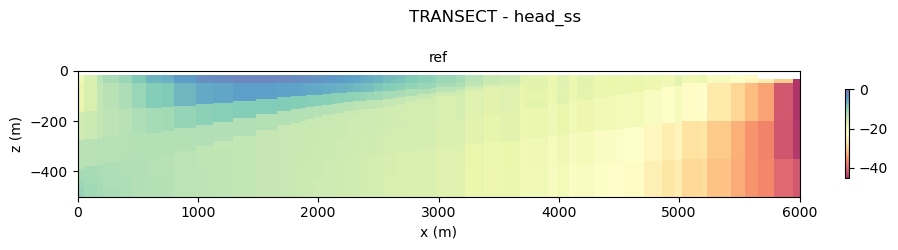

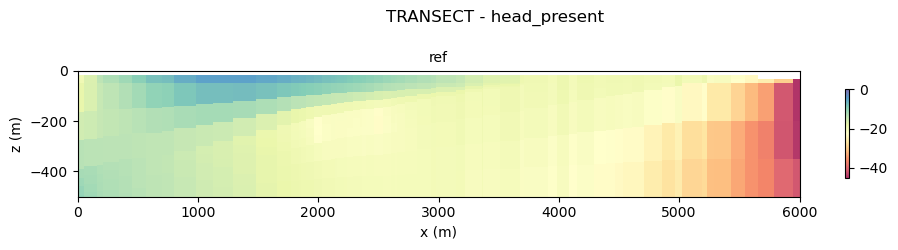

In [11]:
multiplot_prop_transect(P, models = [R], array = 'head_ss', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_present', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,
                        vmin = -45, vmax = 0)

In [12]:
R.gwf, R.head_future, R.obs_future, R.runtime_future = R.write_run_model(P, period = 'Future', ic_array = R.head_present)

Writing simulation and gwf for  ref  ...
ref
Running simulation for  ref  ...
Period =  Future 
Model success =  True
run_time =  185.42702


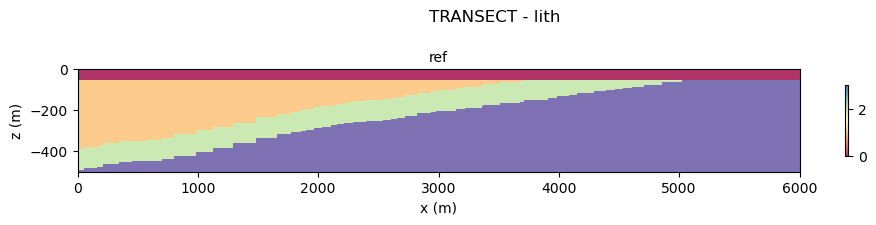

In [13]:
multiplot_vgrid_transect(P, models = [R], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1) 

In [14]:
#f = os.path.join(vtk_workspace, "test", R.modelname)
#R.gwf.export(f, fmt="vtk")

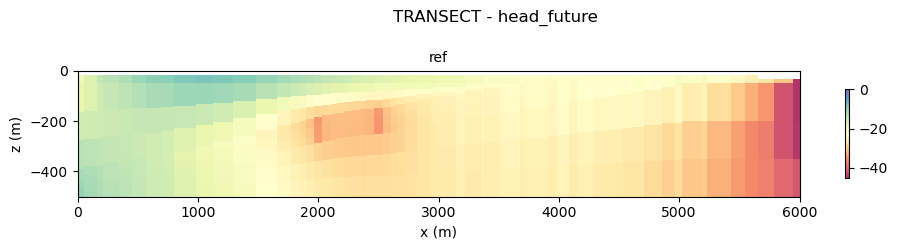

In [15]:
#plot_flow_features(P, [R])
#multiplot_prop_transect(P, models = [R], array = 'logk11', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)
multiplot_prop_transect(P, models = [R], array = 'head_future', 
                        X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 0)


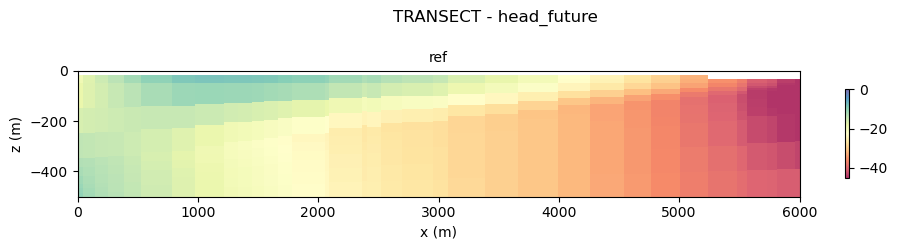

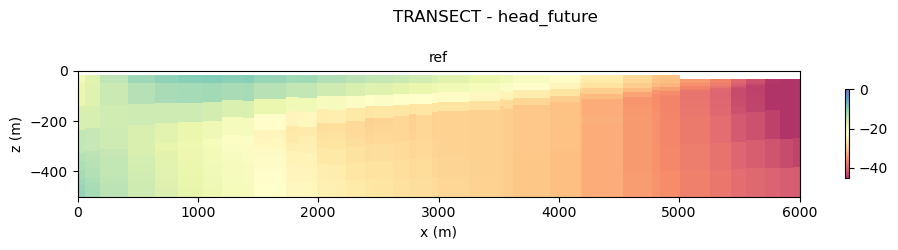

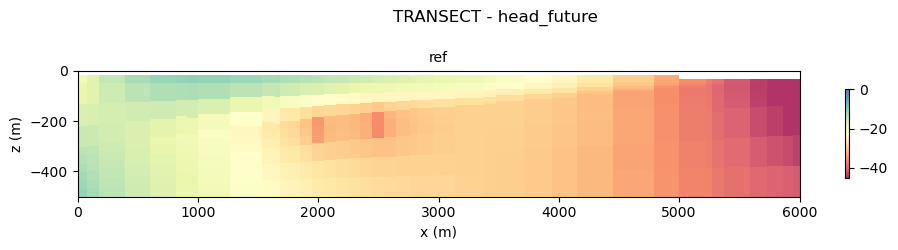

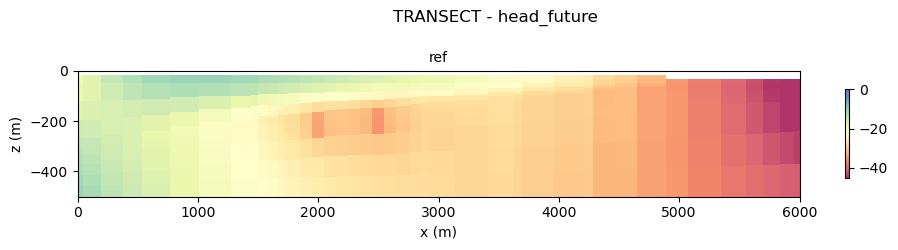

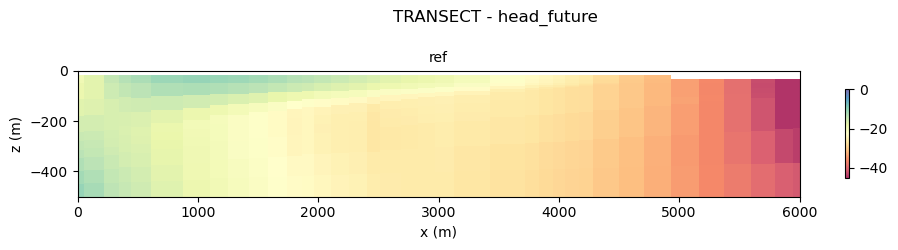

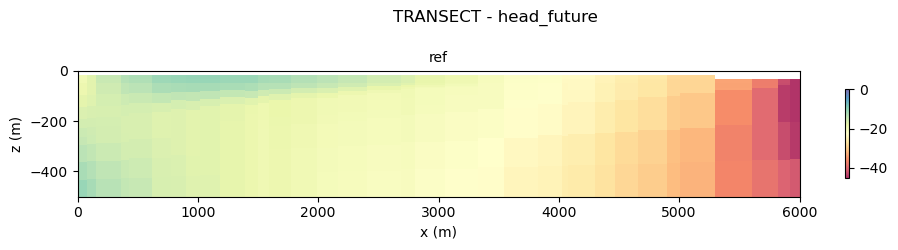

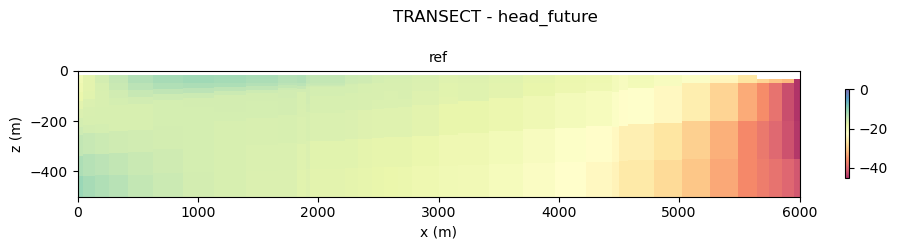

In [16]:
y_ = [1000,1500,2000,2500,3000,4000,5000]
for y in y_:
    multiplot_prop_transect(P, models=[R], array ='head_future',X0=P.x0, Y0=y, X1=P.x1, Y1=y, vmin = -45, vmax = 0)

C:\Users\19904604\AppData\Local\Temp\ipykernel_15780\449695775.py:13: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:


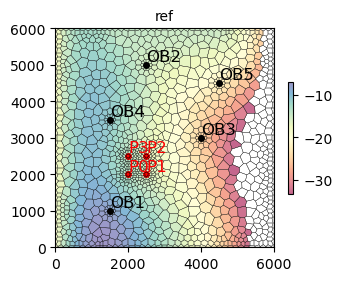

In [17]:
plot_bylayer(P, models = [R], layer = 1)#, vmin = -20, vmax = 5) 

In [18]:
#multiplot_prop_plan(P, models = [R], array = 'k11', layer = 3)#, vmin = None, vmax = None):   # array needs to be a string of a property eg. 'k11', 'logk11'  


### 14. Create "truth" observations and plot observations

In [19]:
R.ref_steady  = process_obs_steady(P, R)
R.ref_past    = process_obs_past(P, R)
R.ref_future  = process_obs_future(P, R)

In [20]:
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    
fname = '../results/ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(P.workspace, fname),'wb'))
fname = '../results/ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(P.workspace, fname),'wb'))

In [21]:
# Get times
csv_file = os.path.join(P.workspace, R.modelname + "_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365

csv_file = os.path.join(P.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2

Text(0, 0.5, 'Head (m)')

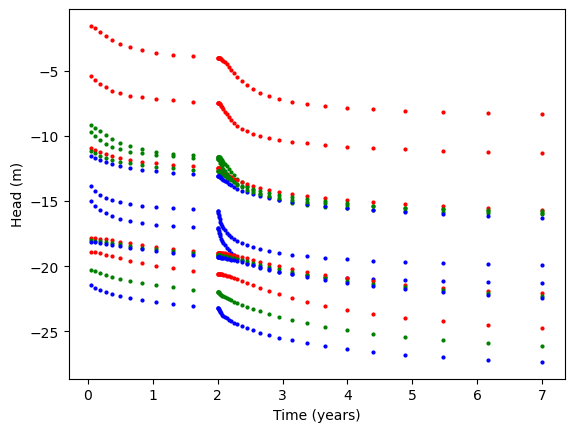

In [22]:
colors = ['red','green','blue']
R.ref_future.shape
for j in range(P.nobs):
    for i in range(P.nzobs):
        plt.plot(times_past, R.ref_past[j][i],'o', ms = 2, color = colors[i])
        plt.plot(times_future, R.ref_future[j][i],'o', ms = 2, color = colors[i])
plt.xlabel('Time (years)')
plt.ylabel('Head (m)')

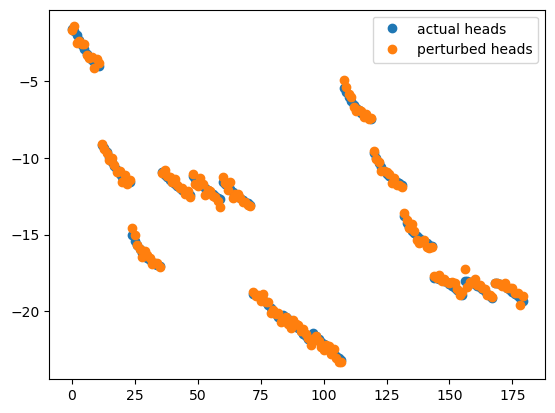

In [23]:
# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.2
hobs_ref = np.copy(R.ref_past)    
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            hobs_ref[i][j][k] += np.random.normal(0.,err) # Perturb samples either side of measurement
plt.plot(R.ref_past.flatten(), 'o', label = 'actual heads')
plt.plot(hobs_ref.flatten(),'o', label = 'perturbed heads')
plt.legend()

### 15. Set up Markov Chain Monte Carlo (MCMC)

#### Define statistics of parameters

In [24]:
def Likelihood(obs,mod,err):
    return(np.sum(-(obs-mod)**2/(2*err**2)))

from DREAM import *

Unif = [] # True = Uniform, False = Normal
Log = []  # ?? Just put False
Mean = []
Width = []  # for uniform distributon the range,  for normal, the standard deviation
Min = []
Max = []

###K values
for i in range(len(P.hk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(np.log10(P.hk[i]))
    Width.append(0.33) # SIGMA
    Min.append(np.log10(P.hk[i])-1) 
    Max.append(np.log10(P.hk[i])+1) 
    
for i in range(len(P.vk)):
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(np.log10(P.vk[i]))
    Width.append(0.33)
    Min.append(np.log10(P.vk[i])-1) 
    Max.append(np.log10(P.vk[i])+1)
    
for i in range(3): # 1e-4 to 1e-6 # Botom 3 layers
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(-4.5)
    Width.append(0.167)
    Min.append(-5) 
    Max.append(-4)
    
#Sy top geo layer #0.05 - 0.2
Unif.append(True)
Log.append(False)
Mean.append(0.125)
Width.append(0.125/2)
Min.append(0.05)
Max.append(0.2)

#Control points z value
Unif.append(True)
Log.append(False)
Mean.append(-125)
Width.append(250)
Min.append(-250)
Max.append(0)

#### Set up DREAM and define "run model" function

In [25]:
## DREAM for Steady State
err = 0.2
nchains = 5     #number of parallel chains 
npars = len(Mean)  #number of parameters
nburn = 20 
nsamples = 100

D = DREAM(nchains, npars, nburn = nburn, npairs = 1) #nburn is burn in perion, npairs defines how you sample
D.par_set(Log,Unif,Mean,Width,Min,Max) #initialise the class
D.set_CR(ncr=3)  #crossover testing thingy. Use 3
D.k = 1  # Number of things to try each chain. Numbers other than 1 can give weird results for some models

#### Run first sample to get first likelihood

In [26]:
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

def update_model(P, loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp):
    del P.hk
    del P.vk
    del P.ss
    del P.sy
    P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3] #[1, 0.1, 10, 0.1] 
    P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3] #[i/10 for i in P.hk]
    P.ss = [0.00005, 10**logss1, 10**logss2, 10**logss3]
    P.sy = [sy0, 0.1, 0.1,0.1]#[sy0, 0.1, 0.1, 0.1]
    P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = Model('run', P, plan = 'vor', transect = 'con') # Create flow model 
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady', ic_array = P.strt)
    M.gwf, M.head_past, M.obs_past, M.runtime_past = M.write_run_model(P, period = 'Past', ic_array = M.head_ss)   
    #hobs_steady = process_obs_steady(P, M)
    hobs_past = process_obs_past(P, M)
    return(hobs_past, M)


------------------------------------------------------
Chain =  0
0.6110148107572829 0.16214784104162008 5.528074393321885 0.10116821166193996 0.10162559726391002 0.0076149636864598835 0.5038799767990618 0.007146901579200554 3.734681153938561e-05 2.3926167834914665e-05 3.465925576866312e-05 0.17902793814617093 -147.39176608752433
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.787858
Creating property arrays for  run  ...
Time taken =  0.010107
Adding flow packages to  run  ...
Time taken =  0.932564
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  30.658164
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Period =  Past 
Model success =  True
run_time =  67.607895
------------------------------------------------------
Chain =  1
0.48733974190121476 0.052714640978449696 7.548678335786327 0.09505348374766065 0.0850789626234975 0.008208785057993249 0.4153602889738247 0.00879075434861554 4.3124962140989434e-05 3.4798902628336225e-05 4.3236592414293535e-05 0.18009210051230784 -211.63922516623006
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.632471
Creating property arrays for  run  ...
Time taken =  0.010156
Adding flow packages to  run  ...
Time taken =  1.063885
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  32.23063
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Period =  Past 
Model success =  True
run_time =  80.168671
------------------------------------------------------
Chain =  2
0.6751065922950281 0.07573821843613208 2.500787550332089 0.05566082939833873 0.11489435915160105 0.013341764179390859 0.9952714945861661 0.005441366356926876 3.9359336300587706e-05 2.3794584482469056e-05 2.9424364456796422e-05 0.07472929941687098 -54.17450976736427
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.485463
Creating property arrays for  run  ...
Time taken =  0.012203
Adding flow packages to  run  ...
Time taken =  1.053971
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  31.681026
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Period =  Past 
Model success =  True
run_time =  58.318169
------------------------------------------------------
Chain =  3
2.1188305604080324 0.0553093115164416 4.9603798234923016 0.04726775411661136 0.09931421462594885 0.016699239037967224 0.4484144970143983 0.005628752172801732 3.8524118729170124e-05 3.5852315004470135e-05 4.3190374903304925e-05 0.12034466614237731 -81.46486234669084
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.478469
Creating property arrays for  run  ...
Time taken =  0.010139
Adding flow packages to  run  ...
Time taken =  1.084788
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  32.871386
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Period =  Past 
Model success =  True
run_time =  61.149848
------------------------------------------------------
Chain =  4
1.6366410660898723 0.10231502343073971 10.622588965028843 0.176918002277544 0.06995848322390326 0.008449298616714734 0.6622375695833528 0.005306341279660053 3.7516232243989066e-05 3.8281614596484336e-05 2.6831321177541232e-05 0.1747960990654827 -207.04812581911912
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.470626
Creating property arrays for  run  ...
Time taken =  0.012184
Adding flow packages to  run  ...
Time taken =  1.129658
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  37.81571
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Period =  Past 
Model success =  True
run_time =  71.706365


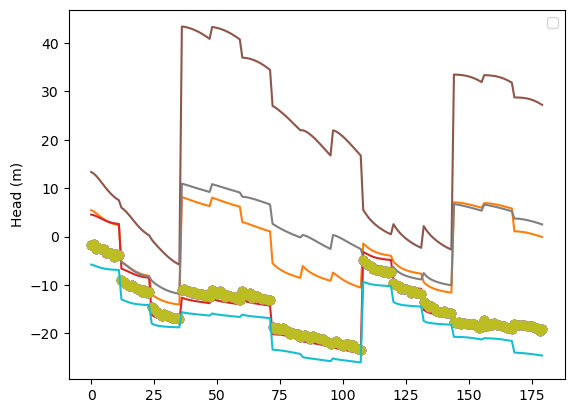

In [27]:
#h_mod_current = [] # list with 1 entry for each chain, that contains the last accepted parameters head result
#h_pred_current = [] # list with 1 entry for each hhaon that saves the predicted heads.    
    
for i in range(nchains):
    print('------------------------------------------------------')
    print("Chain = ", i)
    np.set_printoptions(precision=3)

    print(10**D.chains[i].current[0],
                        10**D.chains[i].current[1],
                        10**D.chains[i].current[2],
                        10**D.chains[i].current[3],
                        10**D.chains[i].current[4],
                        10**D.chains[i].current[5],
                        10**D.chains[i].current[6],
                        10**D.chains[i].current[7],
                        10**D.chains[i].current[8],
                        10**D.chains[i].current[9],
                        10**D.chains[i].current[10],
                        D.chains[i].current[11],
                        D.chains[i].current[12],) 

    hmod, M = update_model(P,
                        D.chains[i].current[0],
                        D.chains[i].current[1],
                        D.chains[i].current[2],
                        D.chains[i].current[3],
                        D.chains[i].current[4],
                        D.chains[i].current[5],
                        D.chains[i].current[6],
                        D.chains[i].current[7],
                        D.chains[i].current[8],
                        D.chains[i].current[9],
                        D.chains[i].current[10],
                        D.chains[i].current[11],
                        D.chains[i].current[12],) 

    a = np.array(hobs_ref) #.flatten()
    b = np.array(hmod) #.flatten()
    D.chains[i].Lold = Likelihood(a,b,err)

    plt.plot(np.array(hobs_ref).flatten(), 'o')
    plt.plot(np.array(hmod).flatten())
    plt.ylabel('Head (m)')
    plt.xlabel('')
    plt.legend()

In [28]:
def run_prediction(M, ic_array):
    M.gwf, M.head_future, M.obs_future, M.runtime_future = M.write_run_model(P, period = 'Future', ic_array = ic_array)   
    hpred = process_obs_future(P, M)
    return hpred

#### Run all samples (LONG TIME TO RUN!)

In [29]:
np.set_printoptions(precision=2)

fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
f = open(fname,'w')  #saves the pars  
f.close()

hobs_past, hobs_pred = [], [] # to save prediction results
for i in range(nsamples):
    for j in range(nchains):
        print("----------Sample = %i, Chain = %i----------" %(i, j))
        prop = D.propgenzs(D.chains[j].current,lookback = 10)
        Lnewdum = np.zeros(D.k)
        for k in range(D.k):
            print('# ------------RUN 1 ------------------#')
            print('range of m = ', D.k) 
            print(10**prop[k,0],  10**prop[k,1],  10**prop[k,2],  10**prop[k,3],  10**prop[k,4],  10**prop[k,5],
                  10**prop[k,6],  10**prop[k,7], 10**prop[k,8], 10**prop[k,9],  10**prop[k,10],  prop[k,11], prop[k,12],) 
            
            hmod, M  = update_model(P, prop[k,0],  prop[k,1],  prop[k,2],  prop[k,3],  prop[k,4],  prop[k,5],
                                       prop[k,6],  prop[k,7],  prop[k,8],  prop[k,9],  prop[k,10],  prop[k,11], prop[k,12],) 
            a = np.array(hobs_ref) #.flatten()
            b = np.array(hmod) #.flatten()
            Lnewdum[k] = Likelihood(a,b, err)
            #print(Lnewdum[k])
            print(prop[k,0],  prop[k,1],  prop[k,2],  prop[k,3],  
                  prop[k,4],  prop[k,5],  prop[k,6],  prop[k,7], 
                  prop[k,8], prop[k,9],  prop[k,10],  prop[k,11], prop[k,12]) 
        L2dum = np.zeros_like(Lnewdum)
        kk = np.argmax(Lnewdum)
        prop2 = D.propgenzs(prop[kk,:],lookback = 10)
        prop2[-1,:] = D.chains[j].current
        L2dum[-1] = D.chains[j].Lold
        for m in range(D.k-1): 
            print('# ------------RUN 2 ------------------#')
            print(10**prop[k,0],  10**prop[k,1],  10**prop[k,2],  10**prop[k,3],  10**prop[k,4],  10**prop[k,5],
                  10**prop[k,6],  10**prop[k,7], 10**prop[k,8], 10**prop[k,9],  10**prop[k,10],  prop[k,11], prop[k,12],) 
            
            hmod, M = update_model(P, prop[m,0],  prop[m,1], prop[m,2],  prop[m,3],  
                                      prop[m,4],  prop[m,5], prop[m,6],  prop[m,7], prop[m,8],
                                      prop[k,9],  prop[k,10],  prop[k,11], prop[k,12],)                                
            
            L2dum[m] = Likelihood(hobs_ref, hmod, err)

        tp = np.sum(Lnewdum)-np.sum(L2dum) # Transition Probability
        print('Last likelihood ' + str(D.chains[j].Lold) + 'Proposed likelihood', str(Lnewdum[kk]))
        if np.random.rand() < np.exp(tp): # If we accept parameters...

            D.chains[j].Lold = Lnewdum[kk]
            D.chains[j].current = prop[kk,:] 
            if i > nburn:                                      # If its past our burn period, we run a prediction...
                print('\nAccepted! Saving parameters and runnning prediction...')
                hobs_past.append(hmod)           # We wants to save head and look at later....
                #----------------------------------------
                hpred = run_prediction(M, ic_array = M.head_past)       # RUN PREDICTION
                hobs_pred.append(hpred)                         # Save the prediction
        D.chains[j].pars = np.vstack((D.chains[j].pars,D.chains[j].current))
        D.chains[j].likelihood = np.append(D.chains[j].likelihood,D.chains[j].Lold)

    D.gen_mod()
    #print(D.rate)
    fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
    f = open(fname,'a')
    for i in range(nchains):
        f.write('%g ' % D.chains[i].Lold)
        for j in range(npars):
            f.write('%g ' %  D.chains[i].current[j])
        f.write('\n')
    f.close()

----------Sample = 0, Chain = 0----------
# ------------RUN 1 ------------------#
range of m =  1
0.6108980244457517 0.16213147488903876 5.528835798459906 0.10116850246037468 0.10163044948408129 0.007615104140847648 0.5038837217407997 0.007146234488132563 3.734633517874526e-05 2.392780968132907e-05 3.466156001928276e-05 0.17903343842069133 -147.4113844008781
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.492787
Creating property arrays for  run  ...
Time taken =  0.010139
Adding flow packages to  run  ...
Time taken =  1.033634
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  30.611633
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  66.676053
-0.21403127931011848 -0.790132666559802 0.742633691967725 -0.9949546785718758 -0.9929761536496522 -2.1183241530651395 -0.2976696715555978 -2.1459227374714955 -4.427752009370363 -4.621097054284549 -4.46015189480965 0.17903343842069133 -147.4113844008781
Last likelihood -471336.96921125014Proposed likelihood -471149.5611650838
----------Sample = 0, Chain = 1----------
# ------------RUN 1 ------------------#
range of m =  1
0.48733716103251323 0.05270421639506044 7.548967099153765 0.09506508888492728 0.08507766468757812 0.008208041497868045 0.41539848545548747 0.008790825601338767 4.3123810563610196e-05 3.479536638451347e-05 4.323840620765582e-05 0.18007939470146725 -211.65550788474542
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.607491
Creating property arrays for  run  ...
Time taken =  0.010163
Adding flow packages to  run  ...
Time taken =  0.921271
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  31.375516
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  82.00071
-0.3121704709991124 -1.2781546393631833 0.8778875325794444 -1.021978941403677 -1.070184439634587 -2.0857604565390884 -0.381535091237423 -2.055970335703461 -4.365282870418021 -4.4584785861574785 -4.364130322766304 0.18007939470146725 -211.65550788474542
Last likelihood -10078.093511435245Proposed likelihood -10093.098261963247
----------Sample = 0, Chain = 2----------
# ------------RUN 1 ------------------#
range of m =  1
0.6751534633721937 0.08969518375968515 1.4929330116921282 0.055674834077884566 0.11489770881384817 0.013339380420605678 0.9954675552861216 0.005440988811062237 3.7717067281943815e-05 2.379516069172592e-05 2.942794242552243e-05 0.0747175412711795 -54.15046765380177
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.603212
Creating property arrays for  run  ...
Time taken =  0.010222
Adding flow packages to  run  ...
Time taken =  0.903365
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  20.917065
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  54.879696
-0.17059750017561753 -1.047230876050088 0.17404032125138266 -1.2543410685762149 -0.9396886315329844 -1.8748643417958557 -0.0019728901215788543 -2.2643221671834035 -4.423462083505886 -4.623511358009825 -4.531240102306797 0.0747175412711795 -54.15046765380177
Last likelihood -3296733.846397983Proposed likelihood -4219150.850765816
----------Sample = 0, Chain = 3----------
# ------------RUN 1 ------------------#
range of m =  1
3.203886460047611 0.06364094946681956 9.7391168100547 0.08109794202658704 0.07878138345347496 0.013494288776884578 0.37073666957142964 0.005562862998070716 3.7670679606584506e-05 3.585287886380721e-05 4.318681584666299e-05 0.16705139246408618 -151.77818914338397
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.480534
Creating property arrays for  run  ...
Time taken =  0.012147
Adding flow packages to  run  ...
Time taken =  0.892909
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  65.261618
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  65.518782
0.5056771170724645 -1.1962633496866042 0.9885195747522368 -1.0909901664773438 -1.1035763969600496 -1.8698500002081782 -0.4309344557699798 -2.254701635711619 -4.423996544736283 -4.4454759662313865 -4.364648815197732 0.16705139246408618 -151.77818914338397
Last likelihood -658034.0883293219Proposed likelihood -48328.85257336576
----------Sample = 0, Chain = 4----------
# ------------RUN 1 ------------------#
range of m =  1
1.6368316410129977 0.10231599184755895 10.622575611225024 0.17692748517739754 0.06996093530345857 0.008449160383144085 0.6624095842467546 0.005306030080714607 3.751650062090968e-05 3.827401383146853e-05 2.6831391816914543e-05 0.17481812305876251 -207.01345551883867
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.613199
Creating property arrays for  run  ...
Time taken =  0.01824
Adding flow packages to  run  ...
Time taken =  0.886817
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  35.207848
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  73.480038
0.21400401164211333 -0.9900564813576179 1.026229831069712 -0.752204695447163 -1.1551443930982248 -2.0731864459715545 -0.17887339247413298 -2.2752302922633514 -4.425777677539914 -4.417095990520466 -4.571356798713522 0.17481812305876251 -207.01345551883867
Last likelihood -31371.722597275904Proposed likelihood -31321.419101888503
----------Sample = 1, Chain = 0----------
# ------------RUN 1 ------------------#
range of m =  1
1.3241291901152985 0.10477171549719075 7.203426126336402 0.09125904849450568 0.09024960253974064 0.009944440576517584 0.43660969464285737 0.006357924944026397 3.7496745334264916e-05 2.8894206535095685e-05 3.8409470883731636e-05 0.17341646424745932 -149.41853017857537
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.59966
Creating property arrays for  run  ...
Time taken =  0.010141
Adding flow packages to  run  ...
Time taken =  0.884986
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  86.736503
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  65.199027
0.12193035958786001 -0.9797559450377065 0.8575391066887468 -1.039724063677975 -1.0445547020558503 -2.0024196430438215 -0.35990662528479817 -2.1966846032830847 -4.426006426797924 -4.539189227211129 -4.415561675491903 0.17341646424745932 -149.41853017857537
Last likelihood -471149.5611650838Proposed likelihood -204013.52737933886
----------Sample = 1, Chain = 1----------
# ------------RUN 1 ------------------#
range of m =  1
0.4872288934286694 0.05272093842149835 7.5469758195194165 0.09505868122680654 0.08506470372568117 0.008208301297757533 0.4153640048896714 0.008791861285545518 4.3206833427108976e-05 3.4797902538027955e-05 5.3993333878932595e-05 0.17645908309749428 -185.6729319332317
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.575942
Creating property arrays for  run  ...
Time taken =  0.012279
Adding flow packages to  run  ...
Time taken =  0.89146
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  31.096605
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  78.277058
-0.3122669652755064 -1.2780168679957755 0.8777729585158303 -1.0220082150769603 -1.0702506062725077 -2.085746710522717 -0.3815711417805071 -2.055919172654332 -4.364447561402867 -4.458446932594019 -4.267659855701156 0.17645908309749428 -185.6729319332317
Last likelihood -10078.093511435245Proposed likelihood -113667.31112688375
----------Sample = 1, Chain = 2----------
# ------------RUN 1 ------------------#
range of m =  1
0.7500875559931323 0.07573222795410271 2.5013559963421845 0.05730161974438284 0.12484783007173623 0.012882413889787432 0.9953916202417283 0.005440496751527727 3.6803568898625053e-05 1.99779743568644e-05 2.6542268080848686e-05 0.07425025732255605 -24.3208367769967
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.516558
Creating property arrays for  run  ...
Time taken =  0.008069
Adding flow packages to  run  ...
Time taken =  0.895327
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  148.952478
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  56.983201
-0.12488803945456896 -1.1207192665486878 0.398175505502798 -1.2418331016607895 -0.9036190015389903 -1.8900027518216822 -0.002006019708226096 -2.2643614446771836 -4.434110065081204 -4.699448548654279 -4.57606196870179 0.07425025732255605 -24.3208367769967
Last likelihood -3296733.846397983Proposed likelihood -3138101.8171181013
----------Sample = 1, Chain = 3----------
# ------------RUN 1 ------------------#
range of m =  1
3.204440207448895 0.07537496444036128 9.73908847740368 0.06317549717269627 0.07877888215666809 0.01692796953212576 0.370608144388395 0.0044474678546328715 3.609734001558144e-05 3.002358140248436e-05 3.6086416718497145e-05 0.16706023557432637 -151.7869807084888
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.49258
Creating property arrays for  run  ...
Time taken =  0.01217
Adding flow packages to  run  ...
Time taken =  0.901804
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  73.216958
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  66.420482
0.5057521723728019 -1.1227728797388041 0.9885183113181767 -1.1994513316239728 -1.1035901859619495 -1.7713951313108798 -0.43108504096943273 -2.351887182222343 -4.442524799731943 -4.522537503612909 -4.4426562400420275 0.16706023557432637 -151.7869807084888
Last likelihood -48328.85257336576Proposed likelihood -63010.59338282711
----------Sample = 1, Chain = 4----------
# ------------RUN 1 ------------------#
range of m =  1
2.0010854685235424 0.10231409952705403 6.34618625653553 0.17695038846480973 0.06995879960500105 0.01042594705935021 0.6625255954224056 0.005305883956988708 3.484171245051003e-05 2.953982675711877e-05 2.6831905692698587e-05 0.12542466246600895 -207.01127124725704
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.492288
Creating property arrays for  run  ...
Time taken =  0.008062
Adding flow packages to  run  ...
Time taken =  1.050032
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  36.755877
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  75.357753
0.3012656382191468 -0.9900645136499145 0.8025128142186244 -0.7521484796049456 -1.1551576510143549 -1.9818844846545824 -0.17879733892173852 -2.2752422525426397 -4.457900507811035 -4.529592056033141 -4.5713484811695855 0.12542466246600895 -207.01127124725704
Last likelihood -31321.419101888503Proposed likelihood -12553.325339646828
----------Sample = 2, Chain = 0----------
# ------------RUN 1 ------------------#
range of m =  1
1.3237523989598015 0.0910597974789687 7.202065138347742 0.053921179152675774 0.11826788780104865 0.010976356986658756 0.4366782914548097 0.006359249013781529 3.846572934093174e-05 2.4073807898070486e-05 3.821875563439377e-05 0.14954511579769417 -61.55830969126051
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.572506
Creating property arrays for  run  ...
Time taken =  0.018222
Adding flow packages to  run  ...
Time taken =  0.887375
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  29.38756
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  60.764279
0.12180676016298998 -1.0406733199169589 0.8574570449854269 -1.2682406191822868 -0.9271331593785824 -1.9595417767453023 -0.3598383975811252 -2.1965941686956056 -4.414926028578134 -4.618455209337721 -4.417723457257823 0.14954511579769417 -61.55830969126051
Last likelihood -204013.52737933886Proposed likelihood -1096267.9979998448
----------Sample = 2, Chain = 1----------
# ------------RUN 1 ------------------#
range of m =  1
0.48735012647383885 0.052714902034193795 7.548218867210408 0.09507460217356911 0.08508620697796977 0.00821002871966896 0.4152926449713938 0.008789839596262646 4.312529116531787e-05 4.202664617694921e-05 4.323657296159918e-05 0.1800794843909011 -211.67049598728872
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.511142
Creating property arrays for  run  ...
Time taken =  0.01015
Adding flow packages to  run  ...
Time taken =  0.90371
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  31.533902
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  75.546737
-0.31215891689412784 -1.2780665962416649 0.8778444844239571 -1.0219354831573493 -1.0701408361417102 -2.0856553236635147 -0.3816457603821121 -2.056019050192853 -4.365267959720084 -4.376475266310542 -4.364148736616278 0.1800794843909011 -211.67049598728872
Last likelihood -10078.093511435245Proposed likelihood -10102.881149155048
----------Sample = 2, Chain = 2----------
# ------------RUN 1 ------------------#
range of m =  1
0.6793076614772485 0.07655037455410287 2.086437945138338 0.04206771596289131 0.14059944576103553 0.013898116594428075 0.8192880830207631 0.005919808015757797 3.679548320189023e-05 1.752239506346325e-05 3.138146291076771e-05 0.0735889129440793 -247.64366326770102
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.381093
Creating property arrays for  run  ...
Time taken =  0.012066
Adding flow packages to  run  ...
Time taken =  1.025012
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  41.77331
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  88.099135
-0.1679334872515684 -1.116052679996653 0.31940547244827117 -1.376051067056946 -0.8520163912891561 -1.8570440492471325 -0.08656336213799644 -2.227692377575896 -4.434205489502801 -4.756406532200193 -4.503326814755933 0.0735889129440793 -247.64366326770102
Last likelihood -3138101.8171181013Proposed likelihood -38919.46069824306
----------Sample = 2, Chain = 3----------
# ------------RUN 1 ------------------#
range of m =  1
4.844790607909208 0.06364497070611454 19.13256003627543 0.08106465359945308 0.06250034229313174 0.010900116052776125 0.37081299316317323 0.005497598205414942 3.6838164402757747e-05 3.585387118893483e-05 4.3183451022762754e-05 0.16705628424313818 -221.36460929225737
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.525529
Creating property arrays for  run  ...
Time taken =  0.012163
Adding flow packages to  run  ...
Time taken =  0.884127
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  22.475035
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  56.414821
0.6852750115633114 -1.196235909070479 1.28177308478117 -1.091168468759233 -1.204117604166145 -1.9625688781316726 -0.43084505672763357 -2.259827003951917 -4.433702018258425 -4.445463946126532 -4.3646826537976615 0.16705628424313818 -221.36460929225737
Last likelihood -48328.85257336576Proposed likelihood -206635.03045313683
----------Sample = 2, Chain = 4----------
# ------------RUN 1 ------------------#
range of m =  1
1.801014377335945 0.06056920036929942 7.337035021484353 0.17190081652068326 0.06438654414448708 0.010798573539693785 0.6053392052070038 0.005844616817340985 3.7261533698356546e-05 3.517993805986215e-05 2.9744469687122063e-05 0.12593543522129771 -236.21238577263267
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.528862
Creating property arrays for  run  ...
Time taken =  0.010058
Adding flow packages to  run  ...
Time taken =  1.014966
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  30.133176
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  76.018364
0.25551717976719723 -1.217748159826762 0.865520592074788 -0.7647220604299638 -1.191204884416449 -1.966633609768159 -0.21800119779786944 -2.233243956626939 -4.428739273352149 -4.453704929525623 -4.526593769687736 0.12593543522129771 -236.21238577263267
Last likelihood -12553.325339646828Proposed likelihood -149094.0494703072
----------Sample = 3, Chain = 0----------
# ------------RUN 1 ------------------#
range of m =  1
1.3251804594010725 0.10478828652466064 9.916377250640895 0.08460283657406745 0.09025320056091793 0.009942608192151302 0.3008078566775412 0.006357393501672998 3.7495866962599434e-05 3.4991061124423405e-05 3.840690224049207e-05 0.17342678923844124 -161.77094784281368
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.510881
Creating property arrays for  run  ...
Time taken =  0.01011
Adding flow packages to  run  ...
Time taken =  0.891955
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  36.201596
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  69.358776
0.12227502331854342 -0.9796872610738278 0.9963530403583027 -1.07261507563931 -1.044537388189069 -2.002499674468344 -0.5217108247720773 -2.196720906342682 -4.426016600385847 -4.456042887082855 -4.415590720018218 0.17342678923844124 -161.77094784281368
Last likelihood -204013.52737933886Proposed likelihood -111094.62192962339
----------Sample = 3, Chain = 1----------
# ------------RUN 1 ------------------#
range of m =  1
0.48734157060439526 0.052698098370338134 7.5487421750942065 0.09509466651606953 0.0850754686904287 0.008209950012339286 0.41530840395333257 0.008790687823855364 4.312645000570144e-05 3.479787737047037e-05 4.3240111294618845e-05 0.18012193513476482 -211.61958592217854
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.637354
Creating property arrays for  run  ...
Time taken =  0.018245
Adding flow packages to  run  ...
Time taken =  0.92422
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  31.873524
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  77.63125
-0.3121665413909784 -1.278205056175868 0.8778745924338704 -1.0218438402402437 -1.0701956496478895 -2.0856594871474656 -0.38162928065600027 -2.055977142398576 -4.3652562897415494 -4.4584472466972995 -4.364113196897806 0.18012193513476482 -211.61958592217854
Last likelihood -10078.093511435245Proposed likelihood -10073.668964828857
----------Sample = 3, Chain = 2----------
# ------------RUN 1 ------------------#
range of m =  1
1.472043163859602 0.04947536972606852 2.717480861843569 0.037946829445512996 0.12483868968289151 0.01815411512172662 0.7099721472519608 0.005266866977594003 3.694624498936954e-05 2.1165238716577292e-05 3.476959719815093e-05 0.06801368052821692 -249.73994891586364
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.492006
Creating property arrays for  run  ...
Time taken =  0.010124
Adding flow packages to  run  ...
Time taken =  0.995654
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  36.458554
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  79.394478
0.1679205447509391 -1.3056109516563532 0.4341664942026746 -1.420824504665489 -0.9036507983732238 -1.7410249148654906 -0.14875868865000863 -2.2784476502444617 -4.432429694299337 -4.674376828881083 -4.458800340540027 0.06801368052821692 -249.73994891586364
Last likelihood -38919.46069824306Proposed likelihood -30842.193792424154
----------Sample = 3, Chain = 3----------
# ------------RUN 1 ------------------#
range of m =  1
3.204482926581582 0.06365911742724768 9.738610075136375 0.08111992823704713 0.07878615678314584 0.013498868606624416 0.3707664548886879 0.005562922078786784 3.7672626746978766e-05 3.585391448800087e-05 4.318885336579474e-05 0.16705926014467437 -151.8209578274054
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.470362
Creating property arrays for  run  ...
Time taken =  0.012091
Adding flow packages to  run  ...
Time taken =  0.894115
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  32.340278
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  64.1168
0.5057579620142784 -1.1961393867507244 0.9884969774358084 -1.0908724422102982 -1.103550084043901 -1.8697026299117068 -0.4308995655624884 -2.2546970232858357 -4.423974097292181 -4.44546342164944 -4.36462832601776 0.16705926014467437 -151.8209578274054
Last likelihood -48328.85257336576Proposed likelihood -48187.73865932748
----------Sample = 3, Chain = 4----------
# ------------RUN 1 ------------------#
range of m =  1
2.7395089349800954 0.08197434944944207 6.093565064830939 0.12296414473720987 0.07396287969580653 0.012974243335484895 0.5052437426137144 0.005423838421248479 3.4909851313531016e-05 2.9542641709508406e-05 3.350160859084646e-05 0.12181949185640742 -180.51409411228724
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.461969
Creating property arrays for  run  ...
Time taken =  0.018284
Adding flow packages to  run  ...
Time taken =  0.887171
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  92.289026
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  71.446526
0.4376727212358585 -1.086322021217165 0.7848714527279961 -0.9102215065512355 -1.1309861882152485 -1.88691796101753 -0.29649905646711294 -2.2656932567894827 -4.457052000909411 -4.529550672579731 -4.47493433966894 0.12181949185640742 -180.51409411228724
Last likelihood -12553.325339646828Proposed likelihood -23394.575542295555
----------Sample = 4, Chain = 0----------
# ------------RUN 1 ------------------#
range of m =  1
1.3257585804672694 0.16217484156569173 7.608629979225814 0.09374447952298186 0.101633497357412 0.009944472461901697 0.3470161924158074 0.006357256411407644 3.734490776804312e-05 3.499223222665871e-05 3.465737051061083e-05 0.17344819965504904 -159.69633818978642
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.506579
Creating property arrays for  run  ...
Time taken =  0.010118
Adding flow packages to  run  ...
Time taken =  1.014262
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  39.118828
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  71.817947
0.12246444660525475 -0.790016517675087 0.8813064641258024 -1.02805429782209 -0.9929631294553498 -2.0024182505447596 -0.45965025975448137 -2.196730271531055 -4.427768608815411 -4.456028352092739 -4.460204390729204 0.17344819965504904 -159.69633818978642
Last likelihood -111094.62192962339Proposed likelihood -135434.40168073346
----------Sample = 4, Chain = 1----------
# ------------RUN 1 ------------------#
range of m =  1
0.39401052527903835 0.05395849157626336 5.12114528069362 0.049049035891680616 0.1097310702176624 0.009662331557826925 0.27379639434425923 0.010532237842218893 4.3105197580397594e-05 2.6262858592587662e-05 6.190673813672962e-05 0.1787416224700804 -152.30000821569408
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  3.797985
Creating property arrays for  run  ...
Time taken =  0.010205
Adding flow packages to  run  ...
Time taken =  1.156354
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  26.615556
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  66.419228
-0.40449217662733866 -1.2679401996462019 0.7093670964179928 -1.309369524696634 -0.9596703850638445 -2.014918064007013 -0.562572275437612 -1.9774793420843024 -4.365470359899821 -4.580658004696648 -4.20826207834114 0.1787416224700804 -152.30000821569408
Last likelihood -10073.668964828857Proposed likelihood -1339949.6416242626
----------Sample = 4, Chain = 2----------
# ------------RUN 1 ------------------#
range of m =  1
4.366911002412294 0.04948117157287276 2.716907590945438 0.03795067869835588 0.12483612392169234 0.014186266459719495 0.47254884472134306 0.005135139280581499 3.2705767767750634e-05 2.116908097928137e-05 3.1707888424250894e-05 0.06801008037125068 -154.69026775856912
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.453914
Creating property arrays for  run  ...
Time taken =  0.010062
Adding flow packages to  run  ...
Time taken =  0.892823
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  True
run_time =  178.583723
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...


Period =  Past 
Model success =  True
run_time =  69.149645
0.6401743410958087 -1.3055600260677718 0.43407486719044297 -1.4207804529090762 -0.9036597243510959 -1.8481318870858934 -0.3255532942519085 -2.2894477725209086 -4.485375651351348 -4.674297995749621 -4.498832678699195 0.06801008037125068 -154.69026775856912
Last likelihood -30842.193792424154Proposed likelihood -148638.26321829052
----------Sample = 4, Chain = 3----------
# ------------RUN 1 ------------------#
range of m =  1
2.3130956438629955 0.04431572724581667 29.409940423897428 0.13853841584208365 0.05832907889273097 0.008304591003851159 0.1547548683691014 0.008986393960433818 4.127408850948941e-05 5.243117510442048e-05 6.34669161787884e-05 0.12243512806468156 -64.97027375360773
{'upper': 0, 'upper_unconformity': 1, 'lower': 2}
Creating lithology and discretisation arrays for  run  ...


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Time taken =  2.594882
Creating property arrays for  run  ...
Time taken =  0.010282
Adding flow packages to  run  ...
Time taken =  0.912939
Writing simulation and gwf for  run  ...
run
Running simulation for  run  ...
Period =  Steady 
Model success =  False


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)
    
fname = '../results/hobs_past.pkl'
pickle.dump(hobs_past, open(os.path.join(P.workspace, fname),'wb'))

fname = '../results/hobs_pred.pkl' 
pickle.dump(hobs_pred, open(os.path.join(P.workspace, fname),'wb'))

In [ ]:
colors = ['b','orange','g','r', 'purple']

for i in range(nchains): # For each chain
    plt.plot(D.chains[i].likelihood, color = colors[i])#, 'o', ms = 2)

plt.ylabel('ln(Likelihood)')
plt.xlabel('Samples')

plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.axvline(nburn)
plt.text(nburn - 40,-200,'Burn in') 
plt.text(nburn + 5,-200,'Sampling')
#plt.ylim(-300000,1000)

#### Plot parameter estimates

In [ ]:
fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
B = np.loadtxt(fname)[:,1:]
n = int(B.shape[0]/nchains)
A = B.reshape((n, nchains, npars))
B.shape

In [ ]:
#fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
#B = np.loadtxt(fname)[nburn*nchains:,1:]
#A = B.reshape((nsamples-nburn, nchains, npars))

In [ ]:
for i in range(npars-1,npars):
    for j in range(nchains):
        plt.plot(A[:,j,i], 'o',ms=3)
plt.plot((0,80),(-200, -200), color = 'black', lw = 3)
plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples x chains')
plt.ylabel('control point z (m)')
plt.axvline(nburn)
plt.ylim(-250,0)

In [ ]:
hk_ref = np.copy(P.hk) 
vk_ref = [i/10 for i in hk_ref]
ss_ref = np.copy(P.ss)
ss_ref = ss_ref[1:]

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (4,3))

ax = plt.subplot(1,2,1)
ax.hist(A[:,:,-1].flatten(), bins=30, range = (-250,0))
plt.axvline(-200, color = 'black', lw = 2)
ax.set_xlabel('Control Point Z (m)')
if i == 0: ax.set_ylabel('Frequency')
#ax.set_ylim([0,300])
ax.set_xlim([-250,0])
#if i != 0: ax.set_yticks([])
    
ax = plt.subplot(1,2,2)
ax.hist(A[:,:,-2].flatten(), bins=30, range = (0,0.2))
plt.axvline(P.sy[0], color = 'black', lw = 2)
ax.set_xlabel('Sy')
if i == 0: ax.set_ylabel('Frequency')
#ax.set_ylim([0,300])
ax.set_xlim([0, 0.2])
#if i != 0: ax.set_yticks([])

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (12,3))
for i in range(4):
    ax = plt.subplot(1,4,i+1)
    ax.hist(A[:,:,i].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 2)
    ax.set_xlabel(f'Log Hk, Lay = {i}')
    if i == 0: ax.set_ylabel('Frequency')
    #ax.set_ylim([0,300])
    ax.set_xlim([-2,2])
    if i != 0: ax.set_yticks([])

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (12,3))
for i in range(4):
    ax = plt.subplot(1,4,i+1)
    ax.hist(A[:,:,i+4].flatten(), bins=30, range = (-3,1))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 2)
    ax.set_xlabel(f'Log Vk, Lay = {i}')
    if i == 0: ax.set_ylabel('Frequency')
    #ax.set_ylim([0,300])
    ax.set_xlim([-3,1])
    if i != 0: ax.set_yticks([])

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (12,3))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    ax.hist(A[:,:,i+8].flatten(), bins=30, range = (-5,-4))
    plt.axvline(logfunc(ss_ref[i]), color = 'black', lw = 2)
    ax.set_xlabel(f'Log Ss, Lay = {i}')
    if i == 0: ax.set_ylabel('Frequency')
    #ax.set_ylim([0,300])
    #ax.set_xlim([-3,1])
    #if i != 0: ax.set_yticks([])

In [ ]:
meanK = []
meanX = []
meanY = []
meanL = []
meanTheta = []
varK = []
varX = []
varY = []
varL = []
varTheta = []
for i in range(1,np.shape(B)[0]):
    meanK.append(np.mean(B[:i,0]))
    varK.append(np.var(B[:i,0]))
    meanX.append(np.mean(B[:i,1]))
    varX.append(np.var(B[:i,1]))
    meanY.append(np.mean(B[:i,2]))
    varY.append(np.var(B[:i,2]))
    meanL.append(np.mean(B[:i,3]))
    varL.append(np.var(B[:i,3]))
    meanTheta.append(np.mean(B[:i,4]))
    varTheta.append(np.var(B[:i,4]))
    


In [ ]:
len(A)

In [ ]:
A.shape

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
for k in range(5):
    for j in range(npars-2):
        for i in range(len(A) - nburn):        
            ax.plot(j, A[i][k][j],'o', ms = 2.)

for j in range(npars-2):
    ax.plot(j, Mean[j], 'o', ms = 5., color = 'black')
#ax.set_xlabel('Parameter Number')
ax.set_xticks(np.arange(0,npars-2,1))
ax.set_xticklabels(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3','ss1','ss2','ss3'])
ax.set_ylabel('Log Value')
ax.set_ylim([-5,1.5])

### Compare predictions against reality

In [ ]:
R.ref_steady.shape

In [ ]:
# PAST

# Get times
csv_file = os.path.join(P.workspace, "ref_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365 

# Load saved observations for future
fname = '../results/ref_past.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_past = pickle.load(pickleoff)
pickleoff.close()
ref_past = np.array(ref_past)
print('ref_past shape', ref_past.shape) 

# Load saved observations for calibrated predictions
fname = '../results/hobs_past.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
obs_past = pickle.load(pickleoff)
pickleoff.close()
obs_past = np.array(obs_past)
print('obs_past shape', obs_past.shape) 

In [ ]:
# FUTURE

# Get times
csv_file = os.path.join(P.workspace, M.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365 

# Load saved observations for future
fname = '../results/ref_future.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_future = pickle.load(pickleoff)
pickleoff.close()
ref_future = np.array(ref_future)
print('ref_future shape', ref_future.shape) 

# Load saved observations for calibrated predictions
fname = '../results/hobs_pred.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
obs_future = pickle.load(pickleoff)
pickleoff.close()
obs_future = np.array(obs_future)
print('obs_future shape', obs_future.shape) #(290, 9, 29)

### Plot reality vs predicted

In [ ]:
print(obs_past.shape) # number of ACCEPTED parameter set past/future results, nobs_xy, nobs_z, nts
print(obs_future.shape)
print(ref_past.shape)
print(ref_future.shape)

In [ ]:
fig = plt.figure(figsize=(12,6))
#plt.suptitle(modelname, size = 14)
colors = ['red', 'blue','green']
for j in range(5):  # OBS in xy
    ax = plt.subplot(3, 2, j+1,aspect='auto')
    ax.set_title('Obs %i' %(j))
        
    for k in range(3): # OBS in z
        for i in range(len(obs_past)): 
            ax.plot(times_past, obs_past[i][j][k], '-', color = colors[k], lw = 0.1 ) 
            
        for i in range(len(obs_future)):
            ax.plot(times_future + 2, obs_future[i][j][k], '-', color = colors[k], lw = 0.1 ) 
        
        ax.plot(times_past, ref_past[j][k], lw = 2, color = colors[k]) # Plot truth
        ax.plot(times_future+2, ref_future[j][k], lw = 2, color = colors[k]) # Plot truth
    #if n > (nobs-4): 
    #    ax.set_xlabel('Time (years)', size = 10)
    #    ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5], labels=[0, 1, 2, 3, 4, 5],size = 10)
    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Head (m)', size = 10)
    #ax.axvline(2)
    #ax.set_ylim([-45,10])
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
ref_future[0][0][-1]

In [ ]:
ref_future[0, 0,-1]

In [ ]:
ref_future[2][1][-1]

In [ ]:
obs_future[:][2][1][-1]

In [ ]:
fig = plt.figure(figsize=(10,8))
#plt.suptitle(modelname, size = 14)

for k in range(3): # OBS in z
    for j in range(5):  # OBS in xy
    
        ax = plt.subplot(3, 5, k * 5 + j + 1,aspect='auto')
        ax.set_title('Obs %i\nz = %i' %(j, k), size = 8)

        ax.hist(obs_future[:][j][k][-1], bins = 10)
        ax.axvline(ref_future[j][k][-1], lw = 2, color = 'black') # Plot truth

        #if n > (nobs-4): ax.set_xlabel('Predicted head (m)', size = 10)
        #if n == 0 or n == 3 or n == 6: ax.set_ylabel('Frequency', size = 10)
        #ax.set_xlim([-50, 0])
        ax.set_xlim([-30, -5])
        #ax.set_xlim([ref_future[j, k, -1] - 15, ref_future[j, k,-1] + 15])
        #ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=[0, 1, 2, 3, 4, 5, 6, 7],size = 10)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
Scrap Code

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
# Plot observations
colors = ['black', 'red', 'green', 'purple', 'orange']
marker_styles = ['s', 's', 's', 'o', 'o', 'o'] #['s', '^', 'p', 's', '^', 'p']    
line_styles = ['dashed', 'dashed','dashed','dotted', 'dotted','dotted','solid']  
fill_color = ['red', 'green', 'purple', 'white', 'white', 'white']
#modelnames = [M.modelname for M in models]

 
#---------- STEADY -------------
models = [M]
fig = plt.figure(figsize = (12,3))
fig.suptitle('Steady state heads')
    
for ob in range(P.nobs): # New figure for each obs bore (OB1, OB2, OB3, OB4)
    ax = plt.subplot(1,5,ob+1)#, aspect = 'equal')
    ax.set_title(P.idobsbores[ob], size = 10) 

    for i, model in enumerate(models): # colored line for each model
        for z in range(len(P.zobs)): # New figure for each obs bore (OB1, OB2, OB3, OB4)
            ax.plot(z, model.hobs_steady[ob,z][0], 'o', c = colors[i],#, marker = marker_styles[i], s = 20,)
                    label = M.modelname)
    
    #ax.set_xlim([10,30])
    ax.set_ylabel('Obs Depth (m)')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(P.zobs)
    ax.set_ylim([-20,10])
    if ob > 0: ax.set_yticks([])
    #ax.set_yticks([30, 40, 50, 60])
    if ob == 0: ax.set_ylabel('Head (m)')
    
            
handles, labels = plt.gca().get_legend_handles_labels()
ax = plt.subplot(1,5,5, aspect = 'equal')
ax.set_axis_off()
ax.legend(handles=handles)
plt.show()

In [ ]:
#for attribute, value in M.__dict__.items(): print(attribute)

In [ ]:
"""workspace = 'vtk_files'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

model_output_dir = os.path.join(workspace, "model_output_test")
M.gwf.export(model_output_dir, fmt="vtk")

from flopy.export import vtk
fname = '{}.hds'.format(M.modelname)
print(os.path.join(P.workspace, fname))
hds = flopy.utils.binaryfile.HeadFile(os.path.join(P.workspace, fname))  


vtkobj = vtk.Vtk(M.gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "KW.vtu"))"""